# Fine-tuning ResNet18 with Cross-Validation for Cyanobacteria Toxicity Classification

**Objective:** Fine-tune a pretrained ResNet18 model using Stratified Group K-Fold cross-validation to classify *Microcoleus anatoxicus* images, including training, evaluation, calibration, and testing on out-of-group samples.

## 1. Setup & Configuration

In [1]:
import os
import subprocess
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import yaml
from PIL import Image
from IPython.display import display
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    accuracy_score
)
from sklearn.model_selection import StratifiedGroupKFold
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset
from torchvision import models, datasets
from torchvision.models import ResNet18_Weights
from tqdm import tqdm

from src.config_utils import load_config

# 1.1 Device Selection Utility
def get_best_device(auto_device='auto'):
    """Get the best available device with fallback."""
    if auto_device == 'auto':
        if torch.backends.mps.is_available():
            try:
                test_tensor = torch.randn(1, device='mps')
                _ = test_tensor @ test_tensor
                print("MPS is available and working")
                return torch.device('mps')
            except Exception as e:
                print(f"MPS test failed: {e}, falling back to CPU")
        if torch.cuda.is_available():
            return torch.device('cuda')
        return torch.device('cpu')
    else:
        return torch.device(auto_device)


def get_memory_info(device):
    """Return memory usage info for the given device."""
    if device.type == 'cuda':
        return f"CUDA Memory Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB"
    elif device.type == 'mps':
        return "Using MPS (Metal Performance Shaders)"
    else:
        return "Using CPU"

In [4]:
# Load configuration and initialize device
config = load_config(path="../configs/config_finetune_resnet18.yaml")
device = get_best_device()
print(f"Using device: {device}")
print(get_memory_info(device))

# Output directories setup
FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_resnet18_cross-validation')
os.makedirs(FIG_OUT, exist_ok=True)

# Generate run ID: date + git commit
today = date.today().isoformat()
commit = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
run_id = f"{today}_{commit}"
print(f"Run ID: {run_id}")

MPS is available and working
Using device: mps
Using MPS (Metal Performance Shaders)
Run ID: 2025-07-28_3319866


## 2. Data Preparation

In [5]:
# 2.1 Data Augmentation Transforms
data_cfg = config['augmentation']

# RandomResizedCrop for scale and aspect ratio variation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=tuple(data_cfg['resize']),
                                 scale=(0.8, 1.0)),
    # Random horizontal flip
    transforms.RandomHorizontalFlip(p=0.5 if data_cfg['horizontal_flip'] else 0.0),
    # Random vertical flip
    transforms.RandomVerticalFlip(p=0.5 if data_cfg['vertical_flip'] else 0.0),
    # Small random rotation
    transforms.RandomRotation(degrees=data_cfg['rotation']),
    # Color jitter for brightness, contrast, saturation, hue
    transforms.ColorJitter(
        brightness=data_cfg['color_jitter']['brightness'],
        contrast=data_cfg['color_jitter']['contrast'],
        saturation=data_cfg['color_jitter']['saturation'],
        hue=data_cfg['color_jitter']['hue']
    ),
    # Convert to tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std']),
    # Random Erasing for spatial dropout
    transforms.RandomErasing(
        p=data_cfg['random_erasing']['p'],
        scale=tuple(data_cfg['random_erasing']['scale']),
        ratio=tuple(data_cfg['random_erasing']['ratio'])
    )
])

# Validation Transforms
val_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std'])
])

In [6]:
# 2.2 Load dataset and prepare Stratified Group K-Fold splits
dataset = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=train_transform
)
targets = np.array(dataset.targets)

# Extract group labels from filenames
paths = [path for path, _ in dataset.samples]
groups = [os.path.basename(p).split('_')[0] for p in paths]

df = pd.DataFrame({'target': targets, 'group': groups})
groups_per_class = df.groupby('target')['group'].nunique().to_dict()
n_non_toxic = groups_per_class.get(0, 0)
n_toxic = groups_per_class.get(1, 0)
print(f"{n_non_toxic} non-toxic strains, {n_toxic} toxic strains")

# Choose number of splits based on minimum number of groups per class
n_splits = min(
    df.groupby('target')['group'].nunique().min(),
    5
)

print(f"Using n_splits = {n_splits}")

sgkf = StratifiedGroupKFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42
)

valid_folds = []
for fold, (train_idx, val_idx) in enumerate(
        sgkf.split(np.zeros(len(targets)), targets, groups)
    ):
    # Skip folds where validation set is single-class
    if len(np.unique(targets[val_idx])) < 2:
        print(f"Skip fold {fold+1} (single class in validation set)")
        continue
    valid_folds.append((fold, train_idx, val_idx))

print(f"{len(valid_folds)} valid folds out of {n_splits}")

9 non-toxic strains, 8 toxic strains
Using n_splits = 5
Skip fold 2 (single class in validation set)
Skip fold 5 (single class in validation set)
3 valid folds out of 5


## 3. Model Definition

In [7]:
# 3.1 EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

In [8]:
# 3.2 Model, Loss Function, Optimizer Setup
device = torch.device(config['training']['device'])
model = models.resnet18(
    weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer with dropout + new head
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(config["training"]["dropout_prob"]),
    nn.Linear(num_ftrs, config['model']['num_classes'])
)

model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [9]:
# 3.3 Training & Evaluation Function
def train_and_eval_fold(fold, train_idx, val_idx):
    # DataLoader Setup
    train_subset = Subset(dataset, train_idx)
    val_dataset_full = datasets.ImageFolder(
        root=os.path.join('..', config['data']['path']),
        transform=val_transform
    )
    val_subset = Subset(val_dataset_full, val_idx)
    train_loader = DataLoader(
        train_subset, batch_size=config['data']['batch_size'],
        shuffle=True, num_workers=config['data']['num_workers']
    )
    val_loader   = DataLoader(
        val_subset, batch_size=config['data']['batch_size'],
        shuffle=False, num_workers=config['data']['num_workers']
    )

    # Warm-up Phase: train only the head
    model = models.resnet18(
        weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
    )
    model.fc = nn.Sequential(
        nn.Dropout(config["training"]["dropout_prob"]),
        nn.Linear(model.fc.in_features, config['model']['num_classes'])
    )
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': []}
    num_epochs = config['training']['epochs']
    warmup_epochs = 5

    print("=== Phase 1: Warm-up head only (5 epochs) ===")

    for name, param in model.named_parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(
        model.fc.parameters(),
        lr=1e-3,
        weight_decay=float(config['training']['weight_decay'])
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
    )

    for epoch in range(1, warmup_epochs+1):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Warmup Epoch {epoch}/{warmup_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Warmup Epoch {epoch}/{warmup_epochs} - Val"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val += loss.item() * inputs.size(0)
        val_loss = running_val / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)
        print(f"Warmup Epoch {epoch} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # Fine-tuning Phase: unfreeze layer4 + head, use OneCycleLR, MixUp/CutMix
    print(f"=== Phase 2: Fine-tuning layer4 + head (up to {num_epochs} epochs) ===")

    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True

    base_lr = float(config['training']['learning_rate'])
    optimizer = torch.optim.AdamW([
        {"params": model.layer4.parameters(), "lr": base_lr * 0.1},
        {"params": model.fc.parameters(), "lr": base_lr},
    ], weight_decay=float(config['training']['weight_decay']))

    steps_per_epoch = len(train_loader)
    total_epochs = num_epochs - warmup_epochs
    scheduler = OneCycleLR(
        optimizer,
        max_lr=base_lr,
        epochs=total_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=float(config['training']['pct_start']),
        anneal_strategy='cos'
    )

    early_stopper = EarlyStopping(patience=3, min_delta=1e-4)

    mixup_alpha = float(config['training']['mixup_alpha'])
    mixup_prob = float(config['training']['mixup_prob'])
    use_cutmix = bool(config['training']['use_cutmix'])
    for epoch in range(warmup_epochs + 1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)

            do_mix = (np.random.rand() < mixup_prob)
            if do_mix:
                lam = np.random.beta(mixup_alpha, mixup_alpha)
                idx = torch.randperm(inputs.size(0)).to(device)

                if use_cutmix:
                    W, H = inputs.size(3), inputs.size(2)
                    cx = np.random.randint(W); cy = np.random.randint(H)
                    w = int(W * np.sqrt(1 - lam)); h = int(H * np.sqrt(1 - lam))
                    x0, x1 = max(cx - w // 2, 0), min(cx + w // 2, W)
                    y0, y1 = max(cy - h // 2, 0), min(cy + h // 2, H)
                    inputs[:, :, y0:y1, x0:x1] = inputs[idx, :, y0:y1, x0:x1]
                else:
                    inputs = lam * inputs + (1 - lam) * inputs[idx]
            optimizer.zero_grad()
            outputs = model(inputs)

            if do_mix:
                loss = lam * criterion(outputs, labels) \
                     + (1 - lam) * criterion(outputs, labels[idx])
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                running_val += criterion(outputs, labels).item() * inputs.size(0)
        val_loss = running_val / len(val_loader.dataset)
        history['val_loss'].append(val_loss)

        if early_stopper(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break

        print(f"Epoch {epoch}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # Fold Evaluation
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

    report = classification_report(
        y_true, y_pred, labels=[0, 1], output_dict=True, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    roc_auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    return {
        'fold': fold + 1,
        'history': history,
        'report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'average_precision': ap,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'best_threshold': best_threshold,
        'best_idx': best_idx
    }

## 4. Training Loop

In [10]:
# Run Cross-Validation
results = []
for i, (fold, train_idx, val_idx) in enumerate(valid_folds):
    print(f"\n=== Training fold {fold+1} ({i+1}/{len(valid_folds)}) ===")
    res = train_and_eval_fold(fold, train_idx, val_idx)
    print(f"Fold {res['fold']} — ROC AUC: {res['roc_auc']:.3f} — AP: {res['average_precision']:.3f}")
    print(pd.DataFrame(res['report']).T[['precision','recall','f1-score','support']])
    results.append(res)
    dir_path = f"../outputs/checkpoints/Switzerland/finetune_resnet18/cross-validation/{run_id}"
    os.makedirs(dir_path, exist_ok=True)
    model_path = os.path.join(dir_path, f"model_fold{fold+1}.pth")
    torch.save(model.state_dict(), model_path)

    print(f"Optimal threshold (max F1) = {res['best_threshold']:.3f}")

# Compute mean and std for metrics
roc_aucs = [r['roc_auc'] for r in results]
aps = [r['average_precision'] for r in results]
print(f"\nMean ROC AUC: {np.mean(roc_aucs):.3f} ± {np.std(roc_aucs):.3f}")
print(f"Mean AP     : {np.mean(aps):.3f} ± {np.std(aps):.3f}")


=== Training fold 1 (1/3) ===
=== Phase 1: Warm-up head only (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


Warmup Epoch 1 — Train Loss: 0.6703 — Val Loss: 1.0017


Warmup Epoch 2/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Warmup Epoch 2 — Train Loss: 0.5616 — Val Loss: 1.1156


Warmup Epoch 3/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Warmup Epoch 3 — Train Loss: 0.5161 — Val Loss: 1.1812


Warmup Epoch 4/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Warmup Epoch 4 — Train Loss: 0.5922 — Val Loss: 1.4894


Warmup Epoch 5/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Warmup Epoch 5 — Train Loss: 0.4676 — Val Loss: 1.3373
=== Phase 2: Fine-tuning layer4 + head (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 6/20 — Train Loss: 0.4935 — Val Loss: 1.4983


Epoch 7/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Epoch 7/20 — Train Loss: 0.4999 — Val Loss: 1.5026


Epoch 8/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Epoch 8/20 — Train Loss: 0.5066 — Val Loss: 1.5247


Epoch 9/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 9/20 — Train Loss: 0.4296 — Val Loss: 1.3055


Epoch 10/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 10/20 — Train Loss: 0.4408 — Val Loss: 1.2299


Epoch 11/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 11/20 — Train Loss: 0.3948 — Val Loss: 1.2973


Epoch 12/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 12/20 — Train Loss: 0.4678 — Val Loss: 1.2971


Epoch 13/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]

Early stopping at epoch 13


Fold 1 — ROC AUC: 0.227 — AP: 0.511
              precision    recall  f1-score    support
0              0.321839  0.777778  0.455285  36.000000
1              0.333333  0.063492  0.106667  63.000000
accuracy       0.323232  0.323232  0.323232   0.323232
macro avg      0.327586  0.420635  0.280976  99.000000
weighted avg   0.329154  0.323232  0.233437  99.000000
Optimal threshold (max F1) = 0.006

=== Training fold 3 (2/3) ===
=== Phase 1: Warm-up head only (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Warmup Epoch 1 — Train Loss: 0.7602 — Val Loss: 0.5749


Warmup Epoch 2/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.98s/it]


Warmup Epoch 2 — Train Loss: 0.6558 — Val Loss: 0.5366


Warmup Epoch 3/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Warmup Epoch 3 — Train Loss: 0.6442 — Val Loss: 0.4288


Warmup Epoch 4/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 4 — Train Loss: 0.6526 — Val Loss: 0.4196


Warmup Epoch 5/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Warmup Epoch 5 — Train Loss: 0.5856 — Val Loss: 0.3869
=== Phase 2: Fine-tuning layer4 + head (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 6/20 — Train Loss: 0.6174 — Val Loss: 0.3821


Epoch 7/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 7/20 — Train Loss: 0.5794 — Val Loss: 0.3836


Epoch 8/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 8/20 — Train Loss: 0.5507 — Val Loss: 0.3436


Epoch 9/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 9/20 — Train Loss: 0.5340 — Val Loss: 0.4523


Epoch 10/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 10/20 — Train Loss: 0.4890 — Val Loss: 0.4499


Epoch 11/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]

Early stopping at epoch 11


Fold 3 — ROC AUC: 0.934 — AP: 0.892
              precision    recall  f1-score     support
0              0.944444  0.764045  0.844720   89.000000
1              0.691176  0.921569  0.789916   51.000000
accuracy       0.821429  0.821429  0.821429    0.821429
macro avg      0.817810  0.842807  0.817318  140.000000
weighted avg   0.852183  0.821429  0.824756  140.000000
Optimal threshold (max F1) = 0.642

=== Training fold 4 (3/3) ===
=== Phase 1: Warm-up head only (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 1 — Train Loss: 0.7461 — Val Loss: 0.6817


Warmup Epoch 2/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 2 — Train Loss: 0.6229 — Val Loss: 0.6548


Warmup Epoch 3/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


Warmup Epoch 3 — Train Loss: 0.6056 — Val Loss: 0.6477


Warmup Epoch 4/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 4 — Train Loss: 0.5571 — Val Loss: 0.6975


Warmup Epoch 5/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 5 — Train Loss: 0.5489 — Val Loss: 0.6197
=== Phase 2: Fine-tuning layer4 + head (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 6/20 — Train Loss: 0.5781 — Val Loss: 0.6386


Epoch 7/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 7/20 — Train Loss: 0.5363 — Val Loss: 0.6481


Epoch 8/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 8/20 — Train Loss: 0.5478 — Val Loss: 0.7357


Epoch 9/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 9/20 — Train Loss: 0.4940 — Val Loss: 0.4777


Epoch 10/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 10/20 — Train Loss: 0.4939 — Val Loss: 0.6312


Epoch 11/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 11/20 — Train Loss: 0.4584 — Val Loss: 0.6797


Epoch 12/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]

Early stopping at epoch 12


Fold 4 — ROC AUC: 0.799 — AP: 0.814
              precision    recall  f1-score     support
0              0.731707  0.810811  0.769231   74.000000
1              0.745455  0.650794  0.694915   63.000000
accuracy       0.737226  0.737226  0.737226    0.737226
macro avg      0.738581  0.730802  0.732073  137.000000
weighted avg   0.738029  0.737226  0.735056  137.000000
Optimal threshold (max F1) = 0.357

Mean ROC AUC: 0.653 ± 0.307
Mean AP     : 0.739 ± 0.164


## 6. Threshold Calibration and Temperature Scaling

In [11]:
# 6.1 Threshold Calibration
# Calibration of optimal thresholds per fold (F1-max)
thresholds = []
for res in results:
    y_true = np.array(res['y_true'])
    y_prob = np.array(res['y_prob'])
    prec, rec, th = precision_recall_curve(y_true, y_prob)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_idx = np.nanargmax(f1)
    best_thresh = th[best_idx]
    thresholds.append(best_thresh)
    print(f"→ Fold {res['fold']} : optimal threshold (F1) = {best_thresh:.3f}")

# Global mean threshold
global_thresh = float(np.mean(thresholds))
print(f"\nGlobal mean threshold (across folds) = {global_thresh:.3f}")

# Store thresholds in config for inference
config.setdefault('inference', {})
config['inference']['threshold_global'] = global_thresh
config['inference']['thresholds_per_fold'] = {}
for i, thr in enumerate(thresholds):
    config['inference']['thresholds_per_fold'][f'fold_{i}'] = float(thr)

# Write updated config
with open(f'../configs/config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)
print("Config updated with optimal thresholds.")

→ Fold 1 : optimal threshold (F1) = 0.006
→ Fold 3 : optimal threshold (F1) = 0.642
→ Fold 4 : optimal threshold (F1) = 0.357

Global mean threshold (across folds) = 0.335
Config updated with optimal thresholds.


In [12]:
# 6.2 Temperature Scaling
class ModelWithTemperature(nn.Module):
    """
    Wrapper around a model to learn a temperature parameter for calibrating logits via NLL on the aggregated validation set.
    """
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model
        # initial temperature = 1
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x):
        logits = self.model(x)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Divide each logit by temperature
        return logits / self.temperature.expand(logits.size(0), -1)

    def set_temperature(self, valid_loader):
        """
        Optimize self.temperature to minimize NLL on valid_loader.
        """
        self.to(device)
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for imgs, labs in valid_loader:
                imgs = imgs.to(device)
                logits = self.model(imgs)
                logits_list.append(logits)
                labels_list.append(labs.to(device))
        logits = torch.cat(logits_list)
        labels = torch.cat(labels_list)

        nll_criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def _eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss

        optimizer.step(_eval)

        print(f"→ Optimal temperature = {self.temperature.item():.3f}")
        return self

In [13]:
# 6.3 Prepare aggregated DataLoader for all validation indices
all_val_idx = []
for _, _, val_idx in valid_folds:
    all_val_idx += list(val_idx)

val_dataset_for_temp = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=val_transform
)

agg_val_dataset = Subset(val_dataset_for_temp, all_val_idx)
agg_val_loader = DataLoader(
    agg_val_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers']
)

# Apply temperature scaling
temp_model = ModelWithTemperature(model)
temp_model.set_temperature(agg_val_loader)
# Save temperature to config
config['inference']['temperature'] = float(temp_model.temperature.item())
with open(f'../configs/config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)
print("Config updated with calibration temperature.")

→ Optimal temperature = 1.192
Config updated with calibration temperature.


## 7. Results Visualization

In [14]:
# 7.1 Metrics Summary
rows = []
for r in results:
    rep = r['report']
    rows.append({
        'fold':        r['fold'],
        'roc_auc':     r['roc_auc'],
        'avg_precision': r['average_precision'],
        'accuracy':    rep['accuracy'],
        'f1_class0':   rep['0']['f1-score'],
        'f1_class1':   rep['1']['f1-score']
    })
df_metrics = pd.DataFrame(rows).set_index('fold')
csv_path = os.path.join(FIG_OUT, f"{run_id}_folds_metrics_report.csv")
df_metrics.to_csv(csv_path, index=True)
print("=== Metrics summary per fold ===")
display(df_metrics)
print("\nMean ± std deviation:")
print(df_metrics.mean().to_frame('mean').join(df_metrics.std().to_frame('std')))

=== Metrics summary per fold ===


,roc_auc,avg_precision,accuracy,f1_class0,f1_class1
fold,,,,,
1,0.226631,0.511389,0.323232,0.455285,0.106667
3,0.934126,0.891699,0.821429,0.844720,0.789916
4,0.798799,0.814452,0.737226,0.769231,0.694915



Mean ± std deviation:
                   mean       std
roc_auc        0.653186  0.375553
avg_precision  0.739180  0.201019
accuracy       0.627296  0.266671
f1_class0      0.689745  0.206527
f1_class1      0.530499  0.370111


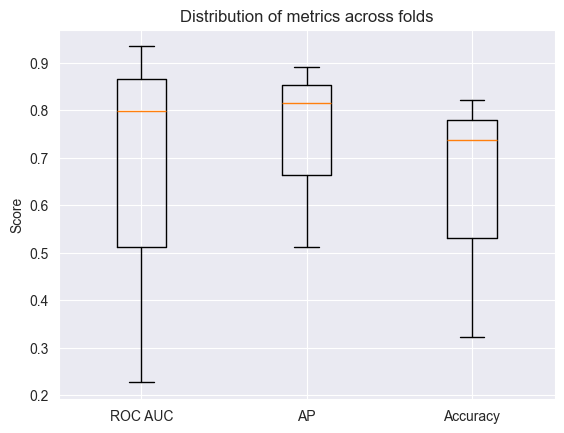

In [16]:
# 7.2 Performance Plots
plt.figure()
plt.boxplot(
    [df_metrics['roc_auc'], df_metrics['avg_precision'], df_metrics['accuracy']],
    tick_labels=['ROC AUC','AP','Accuracy']
)
plt.title("Distribution of metrics across folds")
plt.ylabel("Score")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_metrics.png"), dpi=300)
plt.show()

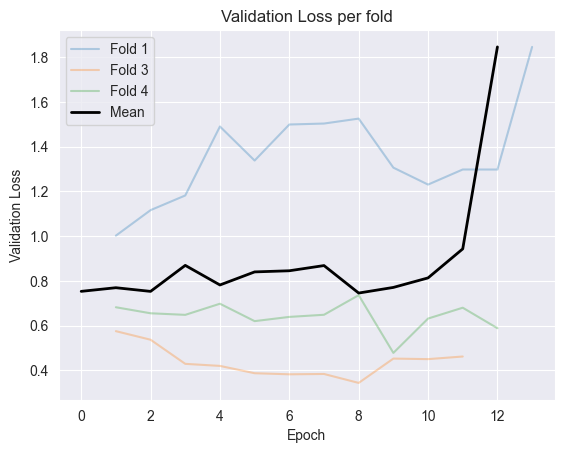

In [17]:
# 7.3 Validation Loss per folds
plt.figure()
for r in results:
    epochs = range(1, len(r['history']['val_loss'])+1)
    plt.plot(epochs, r['history']['val_loss'], alpha=0.3, label=f"Fold {r['fold']}")
# Mean validation loss
mean_val = pd.DataFrame([r['history']['val_loss'] for r in results]).mean()
epochs = mean_val.index
plt.plot(epochs, mean_val, color='black', linewidth=2, label='Mean')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per fold")
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_loss.png"), dpi=300)
plt.show()

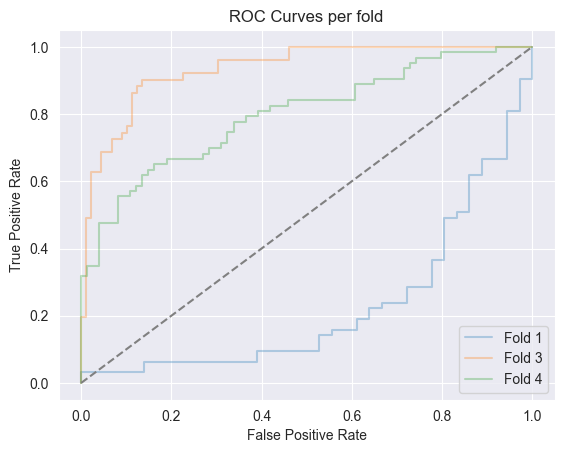

In [18]:
# 7.4 ROC per folds
plt.figure()
for r in results:
    y_true = r['y_true']
    y_prob = r['y_prob']
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {r['fold']}")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per fold")
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_roc.png"), dpi=300)
plt.show()

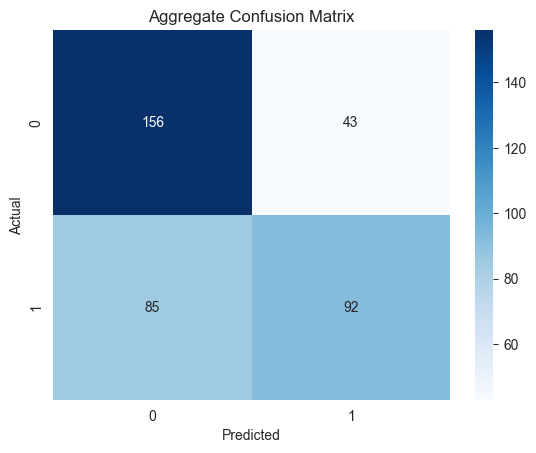

In [19]:
# 7.5 Aggregate Confusion Matrix
cm_sum = sum(r['confusion_matrix'] for r in results)
plt.figure()
sns.heatmap(cm_sum, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Aggregate Confusion Matrix")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_aggregate_confusion_matrix.png"), dpi=300)
plt.show()

## 8. Save Model & Configurations

In [20]:
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
torch.save(model.state_dict(),
           f'../outputs/checkpoints/Switzerland/finetune_resnet18/{run_id}_model.pth')
os.makedirs('../outputs/configs/Switzerland', exist_ok=True)
with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Training complete. Model and config saved.')

Training complete. Model and config saved.


## 9. Out-of-Group Testing

In [21]:
# 9.1 Dataset class
class ToxicityDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        """
        Args:
            root_dirs: list of paths, e.g., ["../data/raw/NewZealand", "../data/raw/USA"]
                Each subdirectory must contain "toxic" and "non_toxic" folders.
            transform: transformation to apply to each image.
        """
        self.samples = []
        self.transform = transform
        for country_dir in root_dirs:
            for label_name, label_id in [("non_toxic", 0), ("toxic", 1)]:
                folder = os.path.join(country_dir, label_name)
                for fname in os.listdir(folder):
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                        self.samples.append((os.path.join(folder, fname), label_id))
        # Optionally: shuffle samples
        # random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [22]:
# 9.2 Testing
# Model and Data Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "../models/cv_resnet18/fold1_model.pth"

# Load Model
model = models.resnet18(weights=None)
in_feats = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=config["training"]["dropout_prob"]),
    torch.nn.Linear(in_feats, 2)
)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device).eval()

# Load out-of-group datasets
country_dirs = ["../data/raw/NewZealand", "../data/raw/USA"]
dataset = ToxicityDataset(country_dirs, transform=val_transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

# Inference loop
all_probs = []
all_preds = []
all_labels = []
th = config['inference']['thresholds_per_fold']['fold_1']
T = config['inference']['temperature']
print(f"Threshold: {th}")
print(f"Temperature: {T}")

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        logits = logits / T
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = (probs >= th)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Evaluation metrics
acc = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
class_names = ['non_toxic', 'toxic']
report = classification_report(all_labels, all_preds, target_names=class_names)
cm = confusion_matrix(all_labels, all_preds)

print(f"Out-of-group (USA+NZ) — Accuracy: {acc:.3f}, AUC: {auc:.3f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

Threshold: 0.6420585513114929
Temperature: 1.1917283535003662
Out-of-group (USA+NZ) — Accuracy: 0.503, AUC: 0.541
Classification Report:
               precision    recall  f1-score   support

   non_toxic       0.52      0.60      0.56        99
       toxic       0.47      0.40      0.43        90

    accuracy                           0.50       189
   macro avg       0.50      0.50      0.50       189
weighted avg       0.50      0.50      0.50       189

Confusion Matrix:
 [[59 40]
 [54 36]]
